In [10]:
import re
from os.path import join
from IPython.display import display

import matplotlib.pyplot as plt
import joblib
import pandas as pd
import numpy as np
import torch
import torch.utils.data as data_utils

from lolip.models.torch_utils.archs import *
from lolip.variables import auto_var
from lolip.models.torch_model import TorchModel
from lolip.utils import estimate_local_lip_v2
from params import mnistLip, cifarLip, svhnLip, mnistOtherLips, mnistFixLips, cifarOtherLips, svhnFixLips
from params import cifarFixLips, svhnOtherLips, resImgFixLips
from utils import params_to_dataframe

TEX_DIR = "./tex_files"

auto_var.set_logging_level(0)

In [6]:
def get_model_name(model_name, hyper=None):
    if 'tulip' in model_name:
        return 3, 'GR'
    elif 'advkld' in model_name:
        return 7, 'AT(KLD)'
    elif 'advce' in model_name:
        return 8, 'AT'
    elif 'pstrades6' in model_name:
        return 21, 'PTRADE(6)'
    elif 'pstrades10' in model_name:
        return 22, 'PTRADE(10)'
    elif 'pstrades' in model_name:
        return 20, 'PTRADE(1)'
    elif 'strades3' in model_name:
        return 11, 'TRADES($\\beta=3$)'
    elif 'strades6' in model_name:
        return 11, 'TRADES($\\beta=6$)'
    elif 'strades10' in model_name:
        return 12, 'TRADES($\\beta=10$)'
    elif 'strades' in model_name:
        return 10, 'TRADES($\\beta=1$)'
    elif 'ptrades6' in model_name:
        return 14, 'PTRADE(6/b)'
    elif 'ptrades10' in model_name:
        return 15, 'PTRADE(10/b)'
    elif 'ptrades' in model_name:
        return 13, 'PTRADE(1/b)'
    elif 'trades6' in model_name:
        return 24, 'TRADES(6/b)'
    elif 'trades10' in model_name:
        return 25, 'TRADES(10/b)'
    elif 'trades' in model_name:
        return 23, 'TRADES(1/b)'
    elif 'cure' in model_name:
        return 5, 'CURE'
    elif 'llr' in model_name:
        return 4, 'LLR'
    elif 'gr' in model_name:
        return 2, 'GRv0'
    elif 'kld' in model_name:
        return 1, 'Natural(kld)'
    else:
        return 0, 'Natural'
    
col_name = {
    'trn_acc': 'tr acc',
    'tst_acc': 'ts acc',
    'adv_trn_acc': 'adv tr acc',
    'adv_tst_acc': 'adv ts acc',
    'avg_trn_lip_kl': 'tr lip(KL)',
    'avg_tst_lip_kl': 'ts lip(KL)',
    'avg_trn_lip_1': 'tr lip(1)',
    'avg_tst_lip_1': 'ts lip(1)',
    'gap': 'gap',
    'adv_gap': 'adv gap',
}

def output_latex(df):
    for name, d in df.groupby(["dataset", "arch", "attack"]):
        d = d.set_index('loss_name')
        d = d.sort_index(axis=0)
        d.index = [i[1] for i in d.index]
        #d = d[['trn_acc', 'tst_acc', 'adv_trn_acc', 'adv_tst_acc', 'avg_trn_lip_1', 'avg_tst_lip_1']]
        d = d[['trn_acc', 'tst_acc', 'adv_tst_acc', 'avg_tst_lip_1', 'gap', 'adv_gap']]
        d = d.rename(columns=col_name)
        tex = d.to_latex(index=True, float_format="%.2f", column_format="lc|cc|c|cc", escape=False)
        with open(join(TEX_DIR, "_".join(name)+"_tab.tex"), "w") as f:
            f.write(tex)
    print(tex)

def display_results(exp, otherExp=None):
    columns = ['trn_acc', 'tst_acc', 'adv_trn_acc', 'adv_tst_acc', 'avg_trn_lip', 'avg_tst_lip']
    _, _, grid_params, _ = exp()()
    df = params_to_dataframe(grid_params,
                             columns=columns,
                             result_file_dir='./results/experiment01/',
                             logging_level=0)
    for c in ['trn_acc', 'tst_acc', 'adv_trn_acc', 'adv_tst_acc']:
        df[c] *= 100
    if otherExp is not None:
        _, _, grid_params, _ = otherExp()()
        add_df = params_to_dataframe(grid_params,
                                 columns=['avg_trn_lip_1', 'avg_tst_lip_1', 'avg_trn_lip_kl', 'avg_tst_lip_kl'],
                                 result_file_dir='./results/experiment03/',
                                 logging_level=0)

        df = df.merge(add_df, how="left", on=['model', 'dataset', 'attack', 'norm', 'eps', 'random_seed'])
    else:
        df['avg_trn_lip_1'] = np.nan
        df['avg_tst_lip_1'] = np.nan
        df['avg_trn_lip_kl'] = np.nan
        df['avg_tst_lip_kl'] = np.nan

    df['arch'] = df['model'].apply(lambda a: a.split("-")[2])
    df['loss_name'] = df['model'].apply(lambda a: get_model_name(a.split("-")[0] if 'aug' not in a.split("-")[0] else a.split("-")[1]))
    df['gen_gap'] = df['trn_acc'] - df['tst_acc']

    for name, d in df.groupby(["dataset", "arch"]):
        print(name)
        display(d)
    return df

def display_results_fix(exp, result_file_dir='./results/experiment02/'):
    columns = ['trn_acc', 'tst_acc', 'adv_trn_acc', 'adv_tst_acc', 'avg_trn_lip_1', 'avg_tst_lip_1']
    _, _, grid_params, _ = exp()()
    df = params_to_dataframe(grid_params,
                             columns=columns,
                             result_file_dir=result_file_dir,
                             logging_level=0)
    for c in ['trn_acc', 'tst_acc', 'adv_trn_acc', 'adv_tst_acc']:
        df[c] *= 100

    df['arch'] = df['model'].apply(lambda a: a.split("-")[2])
    df['loss_name'] = df['model'].apply(lambda a: get_model_name(a.split("-")[0] if 'aug' not in a.split("-")[0] else a.split("-")[1]))
    df['gap'] = df['trn_acc'] - df['tst_acc']
    df['adv_gap'] = df['adv_trn_acc'] - df['adv_tst_acc']

    for name, d in df.groupby(["dataset", "arch", "attack"]):
        print(name)
        display(d)
    return df

In [7]:
df = display_results_fix(mnistFixLips)
for name, d in df.groupby(["dataset", "arch", "attack"]):
    print(name)
    output_latex(d)

E0205 22:56:47.678046 140322810218304 auto_var.py:341] Error with {'attack': 'multitarget', 'dataset': 'mnist', 'eps': 0.1, 'model': 'strades6ce-tor-CNN001', 'norm': 'inf', 'random_seed': 0}


problem with ./results/experiment02/multitarget-mnist-0.1-strades6ce-tor-CNN001-inf-0.pkl
('mnist', 'CNN001', 'multitarget')


,attack,dataset,eps,model,norm,random_seed,trn_acc,tst_acc,adv_trn_acc,adv_tst_acc,avg_trn_lip_1,avg_tst_lip_1,arch,loss_name,gap,adv_gap
7,multitarget,mnist,0.1,strades3ce-tor-CNN001,inf,0,99.210000,98.96,97.936667,96.60,7.727288,7.834208,CNN001,"(11, TRADES($\beta=3$))",0.250000,1.336667
8,multitarget,mnist,0.1,stradesce-tor-CNN001,inf,0,99.806667,99.26,98.650000,96.53,9.619464,9.690696,CNN001,"(10, TRADES($\beta=1$))",0.546667,2.120000
9,multitarget,mnist,0.1,tulipce-tor-CNN001,inf,0,99.988333,99.29,93.286667,89.99,26.081958,26.047614,CNN001,"(3, GR)",0.698333,3.296667
10,multitarget,mnist,0.1,ce-tor-CNN001,inf,0,100.000000,99.20,46.768333,47.30,66.886009,67.246512,CNN001,"(0, Natural)",0.800000,-0.531667
11,multitarget,mnist,0.1,advce-tor-CNN001,inf,0,99.981667,99.31,99.883333,97.23,8.730167,8.840337,CNN001,"(8, AT)",0.671667,2.653333
12,multitarget,mnist,0.1,sllrce-tor-CNN001,inf,0,100.000000,99.43,94.555000,90.49,30.182926,30.435156,CNN001,"(4, LLR)",0.570000,4.065000


('mnist', 'CNN001', 'pgd')


,attack,dataset,eps,model,norm,random_seed,trn_acc,tst_acc,adv_trn_acc,adv_tst_acc,avg_trn_lip_1,avg_tst_lip_1,arch,loss_name,gap,adv_gap
0,pgd,mnist,0.1,strades6ce-tor-CNN001,inf,0,97.500000,97.54,94.046667,93.68,2.838334,2.866431,CNN001,"(11, TRADES($\beta=6$))",-0.040000,0.366667
1,pgd,mnist,0.1,strades3ce-tor-CNN001,inf,0,99.210000,98.96,97.990000,96.66,7.727288,7.834208,CNN001,"(11, TRADES($\beta=3$))",0.250000,1.330000
2,pgd,mnist,0.1,stradesce-tor-CNN001,inf,0,99.806667,99.26,98.696667,96.60,9.619464,9.690696,CNN001,"(10, TRADES($\beta=1$))",0.546667,2.096667
3,pgd,mnist,0.1,tulipce-tor-CNN001,inf,0,99.988333,99.29,94.516667,91.03,26.081958,26.047614,CNN001,"(3, GR)",0.698333,3.486667
4,pgd,mnist,0.1,ce-tor-CNN001,inf,0,100.000000,99.20,60.280000,59.83,66.886009,67.246512,CNN001,"(0, Natural)",0.800000,0.450000
5,pgd,mnist,0.1,advce-tor-CNN001,inf,0,99.981667,99.31,99.883333,97.21,8.730167,8.840337,CNN001,"(8, AT)",0.671667,2.673333
6,pgd,mnist,0.1,sllrce-tor-CNN001,inf,0,100.000000,99.43,96.565000,92.14,30.182926,30.435156,CNN001,"(4, LLR)",0.570000,4.425000


('mnist', 'CNN002', 'multitarget')


,attack,dataset,eps,model,norm,random_seed,trn_acc,tst_acc,adv_trn_acc,adv_tst_acc,avg_trn_lip_1,avg_tst_lip_1,arch,loss_name,gap,adv_gap
20,multitarget,mnist,0.1,strades6ce-tor-CNN002,inf,0,99.613333,99.59,99.535000,98.73,1.351692,1.360831,CNN002,"(11, TRADES($\beta=6$))",0.023333,0.805000
21,multitarget,mnist,0.1,strades3ce-tor-CNN002,inf,0,99.803333,99.57,99.716667,98.54,2.108249,2.142412,CNN002,"(11, TRADES($\beta=3$))",0.233333,1.176667
22,multitarget,mnist,0.1,stradesce-tor-CNN002,inf,0,99.963333,99.58,99.790000,98.06,4.687971,4.741066,CNN002,"(10, TRADES($\beta=1$))",0.383333,1.730000
23,multitarget,mnist,0.1,tulipce-tor-CNN002,inf,0,99.993333,99.55,95.320000,92.93,20.466134,20.264725,CNN002,"(3, GR)",0.443333,2.390000
24,multitarget,mnist,0.1,ce-tor-CNN002,inf,0,100.000000,99.51,80.481667,81.35,23.046890,23.062061,CNN002,"(0, Natural)",0.490000,-0.868333
25,multitarget,mnist,0.1,advce-tor-CNN002,inf,0,99.981667,99.48,99.948333,98.01,6.027635,6.090549,CNN002,"(8, AT)",0.501667,1.938333
26,multitarget,mnist,0.1,sllrce-tor-CNN002,inf,0,100.000000,99.57,95.456667,93.76,9.674707,9.753258,CNN002,"(4, LLR)",0.430000,1.696667


('mnist', 'CNN002', 'pgd')


,attack,dataset,eps,model,norm,random_seed,trn_acc,tst_acc,adv_trn_acc,adv_tst_acc,avg_trn_lip_1,avg_tst_lip_1,arch,loss_name,gap,adv_gap
13,pgd,mnist,0.1,strades6ce-tor-CNN002,inf,0,99.613333,99.59,99.533333,98.73,1.351692,1.360831,CNN002,"(11, TRADES($\beta=6$))",0.023333,0.803333
14,pgd,mnist,0.1,strades3ce-tor-CNN002,inf,0,99.803333,99.57,99.721667,98.54,2.108249,2.142412,CNN002,"(11, TRADES($\beta=3$))",0.233333,1.181667
15,pgd,mnist,0.1,stradesce-tor-CNN002,inf,0,99.963333,99.58,99.800000,98.10,4.687971,4.741066,CNN002,"(10, TRADES($\beta=1$))",0.383333,1.700000
16,pgd,mnist,0.1,tulipce-tor-CNN002,inf,0,99.993333,99.55,96.263333,93.71,20.466134,20.264725,CNN002,"(3, GR)",0.443333,2.553333
17,pgd,mnist,0.1,ce-tor-CNN002,inf,0,100.000000,99.51,85.728333,86.01,23.046890,23.062061,CNN002,"(0, Natural)",0.490000,-0.281667
18,pgd,mnist,0.1,advce-tor-CNN002,inf,0,99.981667,99.48,99.950000,98.03,6.027635,6.090549,CNN002,"(8, AT)",0.501667,1.920000
19,pgd,mnist,0.1,sllrce-tor-CNN002,inf,0,100.000000,99.57,97.413333,95.13,9.674707,9.753258,CNN002,"(4, LLR)",0.430000,2.283333


('mnist', 'CNN001', 'multitarget')
\begin{tabular}{lc|cc|c|cc}
\toprule
{} &  tr acc &  ts acc &  adv ts acc &  ts lip(1) &  gap &  adv gap \\
\midrule
Natural           &  100.00 &   99.20 &       47.30 &      67.25 & 0.80 &    -0.53 \\
GR                &   99.99 &   99.29 &       89.99 &      26.05 & 0.70 &     3.30 \\
LLR               &  100.00 &   99.43 &       90.49 &      30.44 & 0.57 &     4.06 \\
AT                &   99.98 &   99.31 &       97.23 &       8.84 & 0.67 &     2.65 \\
TRADES($\beta=1$) &   99.81 &   99.26 &       96.53 &       9.69 & 0.55 &     2.12 \\
TRADES($\beta=3$) &   99.21 &   98.96 &       96.60 &       7.83 & 0.25 &     1.34 \\
\bottomrule
\end{tabular}

('mnist', 'CNN001', 'pgd')
\begin{tabular}{lc|cc|c|cc}
\toprule
{} &  tr acc &  ts acc &  adv ts acc &  ts lip(1) &   gap &  adv gap \\
\midrule
Natural           &  100.00 &   99.20 &       59.83 &      67.25 &  0.80 &     0.45 \\
GR                &   99.99 &   99.29 &       91.03 &      26.05 &  0.70 

In [13]:
#df = display_results(cifarLip, cifarOtherLips)
df = display_results_fix(cifarFixLips)
for name, d in df.groupby(["dataset", "arch", "attack"]):
    output_latex(d)

E0203 18:00:50.302150 139964346861376 auto_var.py:341] Error with {'attack': 'multitarget', 'dataset': 'cifar10', 'eps': 0.031, 'model': 'aug01-stradesce-tor-WRN_40_10', 'norm': 'inf', 'random_seed': 0}
E0203 18:00:50.361321 139964346861376 auto_var.py:341] Error with {'attack': 'multitarget', 'dataset': 'cifar10', 'eps': 0.031, 'model': 'aug01-strades3ce-tor-WRN_40_10', 'norm': 'inf', 'random_seed': 0}
E0203 18:00:50.420539 139964346861376 auto_var.py:341] Error with {'attack': 'multitarget', 'dataset': 'cifar10', 'eps': 0.031, 'model': 'aug01-strades6ce-tor-WRN_40_10', 'norm': 'inf', 'random_seed': 0}
E0203 18:00:50.480950 139964346861376 auto_var.py:341] Error with {'attack': 'multitarget', 'dataset': 'cifar10', 'eps': 0.031, 'model': 'aug01-advce-tor-WRN_40_10-lrem2', 'norm': 'inf', 'random_seed': 0}
E0203 18:00:50.541947 139964346861376 auto_var.py:341] Error with {'attack': 'multitarget', 'dataset': 'cifar10', 'eps': 0.031, 'model': 'aug01-llrce-tor-WRN_40_10', 'norm': 'inf', 'ra

problem with ./results/experiment02/multitarget-cifar10-0.031-aug01-stradesce-tor-WRN_40_10-inf-0.pkl
problem with ./results/experiment02/multitarget-cifar10-0.031-aug01-strades3ce-tor-WRN_40_10-inf-0.pkl
problem with ./results/experiment02/multitarget-cifar10-0.031-aug01-strades6ce-tor-WRN_40_10-inf-0.pkl
problem with ./results/experiment02/multitarget-cifar10-0.031-aug01-advce-tor-WRN_40_10-lrem2-inf-0.pkl
problem with ./results/experiment02/multitarget-cifar10-0.031-aug01-llrce-tor-WRN_40_10-inf-0.pkl


E0203 18:00:50.602616 139964346861376 auto_var.py:341] Error with {'attack': 'multitarget', 'dataset': 'cifar10', 'eps': 0.031, 'model': 'aug01-sllrce-tor-WRN_40_10-lrem2', 'norm': 'inf', 'random_seed': 0}


problem with ./results/experiment02/multitarget-cifar10-0.031-aug01-sllrce-tor-WRN_40_10-lrem2-inf-0.pkl
('cifar10', 'WRN_40_10', 'multitarget')


,attack,dataset,eps,model,norm,random_seed,trn_acc,tst_acc,adv_trn_acc,adv_tst_acc,avg_trn_lip_1,avg_tst_lip_1,arch,loss_name,gap,adv_gap
7,multitarget,cifar10,0.031,ce-tor-WRN_40_10,inf,0,100.000,88.62,0.000,0.00,347.441545,356.456262,WRN_40_10,"(0, Natural)",11.380,0.000
8,multitarget,cifar10,0.031,tulipce-tor-WRN_40_10,inf,0,99.714,71.68,19.306,12.45,33.186252,33.265875,WRN_40_10,"(3, GR)",28.034,6.856
9,multitarget,cifar10,0.031,stradesce-tor-WRN_40_10,inf,0,100.000,81.61,99.956,37.25,24.386368,30.786882,WRN_40_10,"(10, TRADES($\beta=1$))",18.390,62.706
10,multitarget,cifar10,0.031,strades3ce-tor-WRN_40_10,inf,0,99.988,79.98,99.956,36.01,17.299447,27.383890,WRN_40_10,"(11, TRADES($\beta=3$))",20.008,63.946
11,multitarget,cifar10,0.031,strades6ce-tor-WRN_40_10,inf,0,99.794,78.34,99.738,36.04,11.143698,19.788508,WRN_40_10,"(11, TRADES($\beta=6$))",21.454,63.698
12,multitarget,cifar10,0.031,advce-tor-WRN_40_10,inf,0,99.982,74.00,99.494,32.16,16.087958,16.896749,WRN_40_10,"(8, AT)",25.982,67.334
13,multitarget,cifar10,0.031,sllrce-tor-WRN_40_10-lrem2,inf,0,100.000,85.83,18.882,13.69,77.817010,79.075219,WRN_40_10,"(4, LLR)",14.170,5.192


('cifar10', 'WRN_40_10', 'pgd')


,attack,dataset,eps,model,norm,random_seed,trn_acc,tst_acc,adv_trn_acc,adv_tst_acc,avg_trn_lip_1,avg_tst_lip_1,arch,loss_name,gap,adv_gap
0,pgd,cifar10,0.031,ce-tor-WRN_40_10,inf,0,100.000,88.62,0.000,0.00,347.441545,356.456262,WRN_40_10,"(0, Natural)",11.380,0.000
1,pgd,cifar10,0.031,tulipce-tor-WRN_40_10,inf,0,99.714,71.68,22.950,13.73,33.186252,33.265875,WRN_40_10,"(3, GR)",28.034,9.220
2,pgd,cifar10,0.031,stradesce-tor-WRN_40_10,inf,0,100.000,81.61,99.996,38.06,24.386368,30.786882,WRN_40_10,"(10, TRADES($\beta=1$))",18.390,61.936
3,pgd,cifar10,0.031,strades3ce-tor-WRN_40_10,inf,0,99.988,79.98,99.980,37.03,17.299447,27.383890,WRN_40_10,"(11, TRADES($\beta=3$))",20.008,62.950
4,pgd,cifar10,0.031,strades6ce-tor-WRN_40_10,inf,0,99.794,78.34,99.752,37.33,11.143698,19.788508,WRN_40_10,"(11, TRADES($\beta=6$))",21.454,62.422
5,pgd,cifar10,0.031,advce-tor-WRN_40_10,inf,0,99.982,74.00,99.694,33.09,16.087958,16.896749,WRN_40_10,"(8, AT)",25.982,66.604
6,pgd,cifar10,0.031,sllrce-tor-WRN_40_10-lrem2,inf,0,100.000,85.83,31.480,20.44,77.817010,79.075219,WRN_40_10,"(4, LLR)",14.170,11.040


('cifar10', 'tor', 'multitarget')


,attack,dataset,eps,model,norm,random_seed,trn_acc,tst_acc,adv_trn_acc,adv_tst_acc,avg_trn_lip_1,avg_tst_lip_1,arch,loss_name,gap,adv_gap
22,multitarget,cifar10,0.031,aug01-ce-tor-WRN_40_10,inf,0,100.000,93.81,0.000,0.00,418.622176,425.708713,tor,"(0, Natural)",6.190,0.000
23,multitarget,cifar10,0.031,aug01-tulipce-tor-WRN_40_10,inf,0,94.904,80.74,22.034,19.15,28.566197,28.527540,tor,"(3, GR)",14.164,2.884


('cifar10', 'tor', 'pgd')


,attack,dataset,eps,model,norm,random_seed,trn_acc,tst_acc,adv_trn_acc,adv_tst_acc,avg_trn_lip_1,avg_tst_lip_1,arch,loss_name,gap,adv_gap
14,pgd,cifar10,0.031,aug01-ce-tor-WRN_40_10,inf,0,100.000,93.81,0.002,0.00,418.622176,425.708713,tor,"(0, Natural)",6.190,0.002
15,pgd,cifar10,0.031,aug01-tulipce-tor-WRN_40_10,inf,0,94.904,80.74,25.264,21.32,28.566197,28.527540,tor,"(3, GR)",14.164,3.944
16,pgd,cifar10,0.031,aug01-stradesce-tor-WRN_40_10,inf,0,99.760,84.96,88.260,43.66,25.408692,28.009600,tor,"(10, TRADES($\beta=1$))",14.800,44.600
17,pgd,cifar10,0.031,aug01-strades3ce-tor-WRN_40_10,inf,0,99.780,85.55,94.298,46.63,18.052710,22.423004,tor,"(11, TRADES($\beta=3$))",14.230,47.668
18,pgd,cifar10,0.031,aug01-strades6ce-tor-WRN_40_10,inf,0,98.928,84.46,91.234,48.58,10.059369,13.048935,tor,"(11, TRADES($\beta=6$))",14.468,42.654
19,pgd,cifar10,0.031,aug01-advce-tor-WRN_40_10-lrem2,inf,0,99.842,83.51,93.448,43.51,24.322157,26.230431,tor,"(8, AT)",16.332,49.938
20,pgd,cifar10,0.031,aug01-llrce-tor-WRN_40_10,inf,0,100.000,92.48,20.156,18.23,65.973042,70.279050,tor,"(4, LLR)",7.520,1.926
21,pgd,cifar10,0.031,aug01-sllrce-tor-WRN_40_10-lrem2,inf,0,100.000,91.44,26.548,22.05,91.913977,94.675263,tor,"(4, LLR)",8.560,4.498


\begin{tabular}{lc|cc|c|cc}
\toprule
{} &  tr acc &  ts acc &  adv ts acc &  ts lip(1) &   gap &  adv gap \\
\midrule
Natural           &  100.00 &   88.62 &        0.00 &     356.46 & 11.38 &     0.00 \\
GR                &   99.71 &   71.68 &       12.45 &      33.27 & 28.03 &     6.86 \\
LLR               &  100.00 &   85.83 &       13.69 &      79.08 & 14.17 &     5.19 \\
AT                &   99.98 &   74.00 &       32.16 &      16.90 & 25.98 &    67.33 \\
TRADES($\beta=1$) &  100.00 &   81.61 &       37.25 &      30.79 & 18.39 &    62.71 \\
TRADES($\beta=3$) &   99.99 &   79.98 &       36.01 &      27.38 & 20.01 &    63.95 \\
TRADES($\beta=6$) &   99.79 &   78.34 &       36.04 &      19.79 & 21.45 &    63.70 \\
\bottomrule
\end{tabular}

\begin{tabular}{lc|cc|c|cc}
\toprule
{} &  tr acc &  ts acc &  adv ts acc &  ts lip(1) &   gap &  adv gap \\
\midrule
Natural           &  100.00 &   88.62 &        0.00 &     356.46 & 11.38 &     0.00 \\
GR                &   99.71 &   71.68 &  

In [4]:
df = display_results_fix(svhnFixLips)
for name, d in df.groupby(["dataset", "arch", "attack"]):
    output_latex(d)

('svhn', 'WRN_40_10', 'multitarget')


,attack,dataset,eps,model,norm,random_seed,trn_acc,tst_acc,adv_trn_acc,adv_tst_acc,avg_trn_lip_1,avg_tst_lip_1,arch,loss_name,gap,adv_gap
7,multitarget,svhn,0.031,ce-tor-WRN_40_10,inf,0,99.998635,95.847419,1.498833,1.064075,149.078116,149.817892,WRN_40_10,"(0, Natural)",4.151216,0.434758
8,multitarget,svhn,0.031,stradesce-tor-WRN_40_10,inf,0,98.958461,92.447757,75.621442,46.404425,14.771574,18.750221,WRN_40_10,"(10, TRADES($\beta=1$))",6.510705,29.217017
9,multitarget,svhn,0.031,strades3ce-tor-WRN_40_10,inf,0,99.327027,91.848494,82.115020,49.412262,7.151925,10.151387,WRN_40_10,"(11, TRADES($\beta=3$))",7.478533,32.702758
10,multitarget,svhn,0.031,strades6ce-tor-WRN_40_10,inf,0,97.185252,91.833128,77.099799,52.819607,3.849708,5.199245,WRN_40_10,"(11, TRADES($\beta=6$))",5.352123,24.280193
11,multitarget,svhn,0.031,tulipce-tor-WRN_40_10,inf,0,96.734783,87.799631,16.999058,14.589736,43.381535,40.829995,WRN_40_10,"(3, GR)",8.935152,2.409322
12,multitarget,svhn,0.031,advce-tor-WRN_40_10-lrem2,inf,0,95.200459,92.447757,64.429338,49.469883,12.568644,13.025192,WRN_40_10,"(8, AT)",2.752702,14.959455
13,multitarget,svhn,0.031,sllrce-tor-WRN_40_10,inf,0,99.997270,95.482483,24.418144,20.947296,57.359203,61.644896,WRN_40_10,"(4, LLR)",4.514787,3.470849


('svhn', 'WRN_40_10', 'pgd')


,attack,dataset,eps,model,norm,random_seed,trn_acc,tst_acc,adv_trn_acc,adv_tst_acc,avg_trn_lip_1,avg_tst_lip_1,arch,loss_name,gap,adv_gap
0,pgd,svhn,0.031,ce-tor-WRN_40_10,inf,0,99.998635,95.847419,3.536863,2.662108,149.078116,149.817892,WRN_40_10,"(0, Natural)",4.151216,0.874755
1,pgd,svhn,0.031,stradesce-tor-WRN_40_10,inf,0,98.958461,92.447757,82.767517,50.875845,14.771574,18.750221,WRN_40_10,"(10, TRADES($\beta=1$))",6.510705,31.891672
2,pgd,svhn,0.031,strades3ce-tor-WRN_40_10,inf,0,99.327027,91.848494,87.706294,54.371543,7.151925,10.151387,WRN_40_10,"(11, TRADES($\beta=3$))",7.478533,33.334752
3,pgd,svhn,0.031,strades6ce-tor-WRN_40_10,inf,0,97.185252,91.833128,82.000355,58.124616,3.849708,5.199245,WRN_40_10,"(11, TRADES($\beta=6$))",5.352123,23.875739
4,pgd,svhn,0.031,tulipce-tor-WRN_40_10,inf,0,96.734783,87.799631,20.823949,17.666718,43.381535,40.829995,WRN_40_10,"(3, GR)",8.935152,3.157231
5,pgd,svhn,0.031,advce-tor-WRN_40_10-lrem2,inf,0,95.200459,92.447757,72.540508,55.101414,12.568644,13.025192,WRN_40_10,"(8, AT)",2.752702,17.439094
6,pgd,svhn,0.031,sllrce-tor-WRN_40_10,inf,0,99.997270,95.482483,33.948974,28.042409,57.359203,61.644896,WRN_40_10,"(4, LLR)",4.514787,5.906565


\begin{tabular}{lc|cc|c|cc}
\toprule
{} &  tr acc &  ts acc &  adv ts acc &  ts lip(1) &  gap &  adv gap \\
\midrule
Natural           &  100.00 &   95.85 &        1.06 &     149.82 & 4.15 &     0.43 \\
GR                &   96.73 &   87.80 &       14.59 &      40.83 & 8.94 &     2.41 \\
LLR               &  100.00 &   95.48 &       20.95 &      61.64 & 4.51 &     3.47 \\
AT                &   95.20 &   92.45 &       49.47 &      13.03 & 2.75 &    14.96 \\
TRADES($\beta=1$) &   98.96 &   92.45 &       46.40 &      18.75 & 6.51 &    29.22 \\
TRADES($\beta=3$) &   99.33 &   91.85 &       49.41 &      10.15 & 7.48 &    32.70 \\
TRADES($\beta=6$) &   97.19 &   91.83 &       52.82 &       5.20 & 5.35 &    24.28 \\
\bottomrule
\end{tabular}

\begin{tabular}{lc|cc|c|cc}
\toprule
{} &  tr acc &  ts acc &  adv ts acc &  ts lip(1) &  gap &  adv gap \\
\midrule
Natural           &  100.00 &   95.85 &        2.66 &     149.82 & 4.15 &     0.87 \\
GR                &   96.73 &   87.80 &       17.67

In [9]:
df = display_results_fix(resImgFixLips, result_file_dir='./results/restrictedImgnet3/')
for name, d in df.groupby(["dataset", "arch", "attack"]):
    output_latex(d)

('resImgnet112v3', 'ResNet50', 'multitarget')


,attack,dataset,eps,model,norm,random_seed,trn_acc,tst_acc,adv_trn_acc,adv_tst_acc,avg_trn_lip_1,avg_tst_lip_1,arch,loss_name,gap,adv_gap
0,multitarget,resImgnet112v3,0.005,ce-tor-ResNet50-adambs128,inf,0,97.715986,93.467980,3.919332,4.206897,26733.303523,32228.509789,ResNet50,"(0, Natural)",4.248006,-0.287564
1,multitarget,resImgnet112v3,0.005,stradesce-tor-ResNet50-adambs128,inf,0,97.393190,92.266010,86.049940,79.438424,2148.246010,2144.655471,ResNet50,"(10, TRADES($\beta=1$))",5.127180,6.611517
2,multitarget,resImgnet112v3,0.005,strades3ce-tor-ResNet50-adambs128,inf,0,95.743905,90.748768,88.334342,82.000000,385.736226,396.667848,ResNet50,"(11, TRADES($\beta=3$))",4.995136,6.334342
3,multitarget,resImgnet112v3,0.005,strades6ce-tor-ResNet50-adambs128,inf,0,93.338067,88.916256,87.168475,81.862069,202.860269,200.902166,ResNet50,"(11, TRADES($\beta=6$))",4.421810,5.306406
4,multitarget,resImgnet112v3,0.005,advce-tor-ResNet50-adambs128,inf,0,96.222279,90.325123,90.177615,81.911330,283.740092,287.968701,ResNet50,"(8, AT)",5.897156,8.266285
5,multitarget,resImgnet112v3,0.005,sllr36ce-tor-ResNet50-adambs128,inf,0,98.759253,93.438424,49.799029,50.157635,3862.719966,4795.655284,ResNet50,"(4, LLR)",5.320830,-0.358607
6,multitarget,resImgnet112v3,0.005,tulipce-tor-ResNet50-adambs128,inf,0,91.120397,88.512315,60.372922,60.551724,813.947032,886.746427,ResNet50,"(3, GR)",2.608081,-0.178802


('resImgnet112v3', 'ResNet50', 'pgd')


,attack,dataset,eps,model,norm,random_seed,trn_acc,tst_acc,adv_trn_acc,adv_tst_acc,avg_trn_lip_1,avg_tst_lip_1,arch,loss_name,gap,adv_gap
7,pgd,resImgnet112v3,0.005,ce-tor-ResNet50-adambs128,inf,0,97.715986,93.467980,7.347487,7.901478,26733.303523,32228.509789,ResNet50,"(0, Natural)",4.248006,-0.553991
8,pgd,resImgnet112v3,0.005,stradesce-tor-ResNet50-adambs128,inf,0,97.393190,92.266010,86.544221,79.891626,2148.246010,2144.655471,ResNet50,"(10, TRADES($\beta=1$))",5.127180,6.652596
9,pgd,resImgnet112v3,0.005,strades3ce-tor-ResNet50-adambs128,inf,0,95.743905,90.748768,88.674209,82.275862,385.736226,396.667848,ResNet50,"(11, TRADES($\beta=3$))",4.995136,6.398347
10,pgd,resImgnet112v3,0.005,strades6ce-tor-ResNet50-adambs128,inf,0,93.338067,88.916256,87.432686,82.128079,202.860269,200.902166,ResNet50,"(11, TRADES($\beta=6$))",4.421810,5.304607
11,pgd,resImgnet112v3,0.005,advce-tor-ResNet50-adambs128,inf,0,96.222279,90.325123,90.473641,82.216749,283.740092,287.968701,ResNet50,"(8, AT)",5.897156,8.256892
12,pgd,resImgnet112v3,0.005,sllr36ce-tor-ResNet50-adambs128,inf,0,98.759253,93.438424,52.751137,52.541872,3862.719966,4795.655284,ResNet50,"(4, LLR)",5.320830,0.209265
13,pgd,resImgnet112v3,0.005,tulipce-tor-ResNet50-adambs128,inf,0,91.120397,88.512315,62.263529,62.068966,813.947032,886.746427,ResNet50,"(3, GR)",2.608081,0.194563


\begin{tabular}{lc|cc|c|cc}
\toprule
{} &  tr acc &  ts acc &  adv ts acc &  ts lip(1) &  gap &  adv gap \\
\midrule
Natural           &   97.72 &   93.47 &        4.21 &   32228.51 & 4.25 &    -0.29 \\
GR                &   91.12 &   88.51 &       60.55 &     886.75 & 2.61 &    -0.18 \\
LLR               &   98.76 &   93.44 &       50.16 &    4795.66 & 5.32 &    -0.36 \\
AT                &   96.22 &   90.33 &       81.91 &     287.97 & 5.90 &     8.27 \\
TRADES($\beta=1$) &   97.39 &   92.27 &       79.44 &    2144.66 & 5.13 &     6.61 \\
TRADES($\beta=3$) &   95.74 &   90.75 &       82.00 &     396.67 & 5.00 &     6.33 \\
TRADES($\beta=6$) &   93.34 &   88.92 &       81.86 &     200.90 & 4.42 &     5.31 \\
\bottomrule
\end{tabular}

\begin{tabular}{lc|cc|c|cc}
\toprule
{} &  tr acc &  ts acc &  adv ts acc &  ts lip(1) &  gap &  adv gap \\
\midrule
Natural           &   97.72 &   93.47 &        7.90 &   32228.51 & 4.25 &    -0.55 \\
GR                &   91.12 &   88.51 &       62.07

In [19]:
df = display_results_fix(resImgFixLips, result_file_dir='./results/restrictedImgnet3/')
for name, d in df.groupby(["dataset", "arch"]):
    output_latex(d)

('resImgnet112v3', 'ResNet50')


,attack,dataset,eps,model,norm,random_seed,trn_acc,tst_acc,adv_trn_acc,adv_tst_acc,avg_trn_lip_1,avg_tst_lip_1,arch,loss_name,gap,adv_gap
0,pgd,resImgnet112v3,0.005,ce-tor-ResNet50-adambs128,inf,0,97.715986,93.467980,7.382017,7.842365,26733.303523,32228.509789,ResNet50,"(0, Natural)",4.248006,-0.460348
1,pgd,resImgnet112v3,0.005,stradesce-tor-ResNet50-adambs128,inf,0,97.393190,92.266010,86.544221,79.891626,2148.246010,2144.655471,ResNet50,"(10, TRADES($\beta=1$))",5.127180,6.652596
2,pgd,resImgnet112v3,0.005,strades3ce-tor-ResNet50-adambs128,inf,0,95.743905,90.748768,88.674597,82.275862,385.736226,396.667848,ResNet50,"(11, TRADES($\beta=3$))",4.995136,6.398735
3,pgd,resImgnet112v3,0.005,strades6ce-tor-ResNet50-adambs128,inf,0,93.338067,88.916256,87.425703,82.118227,202.860269,200.902166,ResNet50,"(11, TRADES($\beta=6$))",4.421810,5.307476
4,pgd,resImgnet112v3,0.005,advce-tor-ResNet50-adambs128,inf,0,96.222279,90.325123,90.473253,82.216749,283.740092,287.968701,ResNet50,"(8, AT)",5.897156,8.256504
5,pgd,resImgnet112v3,0.005,sllr36ce-tor-ResNet50-adambs128,inf,0,98.759253,93.438424,52.751913,52.541872,3862.719966,4795.655284,ResNet50,"(4, LLR)",5.320830,0.210041
6,pgd,resImgnet112v3,0.005,tulipce-tor-ResNet50-adambs128,inf,0,91.120397,88.512315,62.263141,62.068966,813.947032,886.746427,ResNet50,"(3, GR)",2.608081,0.194175


\begin{tabular}{lc|cc|c|cc}
\toprule
{} &  tr acc &  ts acc &  adv ts acc &  ts lip(1) &  gap &  adv gap \\
\midrule
Natural           &   97.72 &   93.47 &        7.84 &   32228.51 & 4.25 &    -0.46 \\
GR                &   91.12 &   88.51 &       62.07 &     886.75 & 2.61 &     0.19 \\
LLR               &   98.76 &   93.44 &       52.54 &    4795.66 & 5.32 &     0.21 \\
AT                &   96.22 &   90.33 &       82.22 &     287.97 & 5.90 &     8.26 \\
TRADES($\beta=1$) &   97.39 &   92.27 &       79.89 &    2144.66 & 5.13 &     6.65 \\
TRADES($\beta=3$) &   95.74 &   90.75 &       82.28 &     396.67 & 5.00 &     6.40 \\
TRADES($\beta=6$) &   93.34 &   88.92 &       82.12 &     200.90 & 4.42 &     5.31 \\
\bottomrule
\end{tabular}



In [25]:
result_files = [
    "./results/record/pgd-mnist-0.1-ce-tor-CNN002-ep50-inf-0.pkl",
    "./results/record/pgd-mnist-0.1-tulipce-tor-CNN002-ep50-inf-0.pkl",
    "./results/record/pgd-mnist-0.1-sllrce-tor-CNN002-ep50-inf-0.pkl",
    "./results/record/pgd-mnist-0.1-advce-tor-CNN002-ep50-inf-0.pkl",
    "./results/record/pgd-mnist-0.1-strades6ce-tor-CNN002-ep50-inf-0.pkl",
]
algo_name = ['natural', 'GR', 'LLR', 'AT', 'TRADES(6)', ]

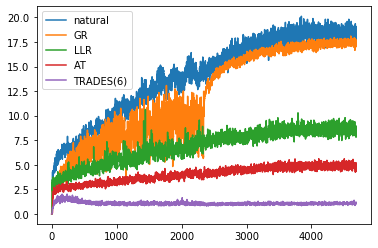

In [30]:
for i, fn in enumerate(result_files):
    a = joblib.load(fn)
    #acc = [x['tst_acc'] for x in a['logger_dict']]
    #adv = [x['tst_adv_acc'] for x in a['logger_dict']]
    lip = [x['tst_lip'] for x in a['logger_dict']]

    plt.plot(lip, label=algo_name[i])
    plt.legend()
    plt.savefig("./figs/mnist_CNN002_lip.png")

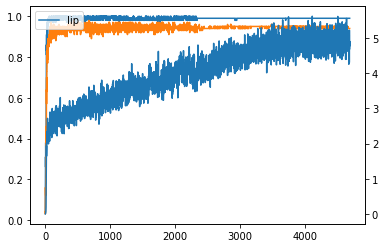

In [20]:
a = joblib.load("./results/record/pgd-mnist-0.1-advce-tor-CNN002-ep50-inf-0.pkl")
acc = [x['tst_acc'] for x in a['logger_dict']]
adv = [x['tst_adv_acc'] for x in a['logger_dict']]
lip = [x['tst_lip'] for x in a['logger_dict']]

fig, ax1 = plt.subplots()

ax1.plot(acc, label="acc")
ax1.plot(adv, label="adv acc")

ax2 = ax1.twinx() 

ax2.plot(lip, label="lip")
plt.legend()

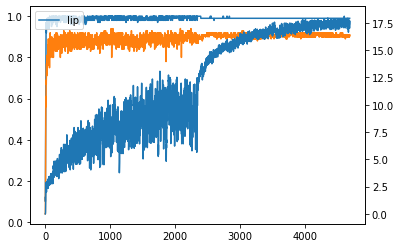

In [23]:
a = joblib.load("./results/record/pgd-mnist-0.1-tulipce-tor-CNN002-ep50-inf-0.pkl")
acc = [x['tst_acc'] for x in a['logger_dict']]
adv = [x['tst_adv_acc'] for x in a['logger_dict']]
lip = [x['tst_lip'] for x in a['logger_dict']]

fig, ax1 = plt.subplots()

ax1.plot(acc, label="acc")
ax1.plot(adv, label="adv acc")

ax2 = ax1.twinx() 

ax2.plot(lip, label="lip")
plt.legend()

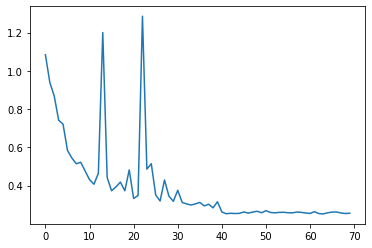

In [17]:
a = joblib.load("./results/restrictedImgnet/pgd-resImgnet112v3-0.005-stradesce-tor-ResNet50-adambs128-inf-0.pkl")
plt.plot([i['tst_loss'] for i in a['history']])

In [3]:
from scipy.special import softmax

def get_arch(path):
    return path.split("-")[path.split("-").index('tor')+1]

def get_ds(path):
    return path.split("-")[1]

def predict_real(model, X):
    X = X.transpose(0, 3, 1, 2)
    dataset = data_utils.TensorDataset(torch.from_numpy(X).float())
    loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False, num_workers=2)
    ret = []
    for [x] in loader:
        ret.append(model(x.to('cuda')).detach().cpu().numpy())
    return np.concatenate(ret, axis=0)

def calc_lip(model, X, Xp, top_norm, btm_norm):
    top = np.linalg.norm(predict_real(model, X)-predict_real(model, Xp), ord=top_norm, axis=1)
    down = np.linalg.norm(X.reshape(len(Xp), -1)-Xp.reshape(len(Xp), -1), ord=btm_norm, axis=1)
    return top / (down+1e-6)

def get_lip(model, X, top_norm=2, btm_norm=2, epsilon=1.0):
    lip = estimate_local_lip_v2(model, X, top_norm=top_norm, btm_norm=btm_norm, epsilon=epsilon)
    lip_ = calc_lip(model, X, lip, top_norm=top_norm, btm_norm=btm_norm)
    return lip_

class ModelWrapper():
    def __init__(self, model):
        self.model = model
    def predict_proba(self, X):
        return softmax(predict_real(self.model, X), axis=1)
    def predict_real(self, X):
        return predict_real(self.model, X)
    def predict(self, X):
        return predict_real(self.model, X).argmax(axis=1)
    
cifar_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [9]:
model_path = "./models/pgd-cifar10-0.031-advce-tor-WRN_40_10-inf-0.pt"
model = globals()[get_arch(model_path)](n_classes=10)
model.load_state_dict(torch.load(model_path))
model.eval()
model.cuda()
model = ModelWrapper(model)
trnX, trny, tstX, tsty = auto_var.get_var_with_argument("dataset", get_ds(model_path))

In [11]:
pred = model.predict_proba(trnX)
log_loss = np.array([np.log(pred[i][trny[i]]) for i in range(len(pred))])

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 4.0000e+00, 1.0000e+01,
        1.5000e+01, 2.2000e+01, 5.0000e+01, 8.7000e+01, 4.9811e+04]),
 array([-1.5260077 , -1.3734069 , -1.2208061 , -1.0682054 , -0.9156046 ,
        -0.7630038 , -0.61040306, -0.4578023 , -0.30520153, -0.15260077,
         0.        ], dtype=float32),
 <a list of 10 Patch objects>)

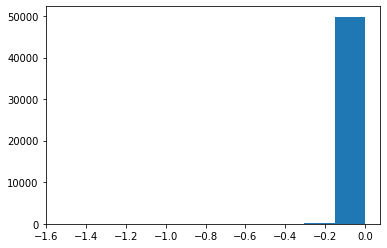

In [13]:
plt.hist(log_loss)

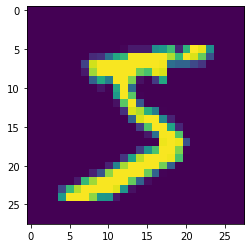

In [10]:
trnX, trny, tstX, tsty = auto_var.get_var_with_argument("dataset", 'mnist')
plt.imshow(trnX[0, :, :, 0])

In [12]:
from scipy import fftpack
im = trnX[0, :, :, 0]
im_fft = fftpack.fft2(im)

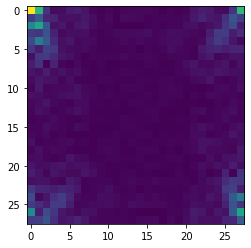

In [16]:
plt.imshow(np.abs(im_fft))

In [4]:
from lolip.utils import estimate_local_mse
model_path = "./models/pgd-cifar10-0.031-aug01-ce-tor-WRN_40_10-inf-0-ep0120.pt"
model = globals()[get_arch(model_path)](n_classes=10)
model.load_state_dict(torch.load(model_path)['model_state_dict'])
model.eval()
model.cuda()
trnX, trny, tstX, tsty = auto_var.get_var_with_argument("dataset", get_ds(model_path))
ret = estimate_local_mse(model, trnX[:100])
print(ret[0])

12.135422058105469


In [280]:
from lolip.attacks.torch.projected_gradient_descent import ProjectedGradientDescent
n = 10000
i = 2
nb_iter=10
eps = 0.05
attack_model = ProjectedGradientDescent(
    model_fn=model.model,
    norm=np.inf,
    eps=eps,
    eps_iter=eps*2/nb_iter,
    nb_iter=nb_iter,
)
adv_tstX = attack_model.perturb(tstX[:n], tsty[:n])
pred = model.predict_proba(tstX[:n])
advpred = model.predict_proba(adv_tstX[:n])
proba = np.array([pred[i][tsty[i]] for i in range(n)])
advproba = np.array([advpred[i][tsty[i]] for i in range(n)])

W0106 15:42:14.924072 140719580231488 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true class: 8
prediction: 8, proba: 0.7208942174911499
prediction: 2, proba: 1.0


[]

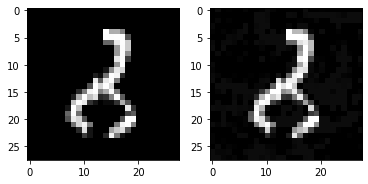

In [271]:
i=582
#i=78
print(f"true class: {int(tsty[i])}")
print(f"prediction: {int(pred.argmax(1)[i])}, proba: {pred.max(1)[i]}")
print(f"prediction: {int(advpred.argmax(1)[i])}, proba: {advpred.max(1)[i]}")

f = plt.figure()
f.add_subplot(1, 2, 1)
plt.imshow(np.concatenate([tstX[i], tstX[i], tstX[i]], axis=2))
f.add_subplot(1, 2, 2)
plt.imshow(np.concatenate([adv_tstX[i], adv_tstX[i], adv_tstX[i]], axis=2))
plt.plot()

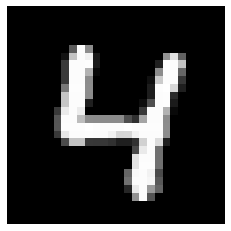

In [215]:
plt.axis('off')
plt.imshow(np.concatenate([tstX[i], tstX[i], tstX[i]], axis=2))
#plt.imshow(np.concatenate([adv_tstX[i], adv_tstX[i], adv_tstX[i]], axis=2))
plt.savefig("./figs/mnist_img2.png", transparent=True)

In [122]:
model_path = "./models/pgd-cifar10-0.031-ce-tor-WRN_40_10-inf-0.pt"
model = globals()[get_arch(model_path)](n_classes=10)
model.load_state_dict(torch.load(model_path))
model.eval()
model.cuda()
model = ModelWrapper(model)
trnX, trny, tstX, tsty = auto_var.get_var_with_argument("dataset", get_ds(model_path))

a = joblib.load("./results/experiment03/pgd-cifar10-0.031-ce-tor-WRN_40_10-inf-0.pkl")

In [123]:
n = 100
pred = model.predict_proba(tstX[:n])
advpred = model.predict_proba(a['tst_lip_1_pert'][:n])
proba = np.array([pred[i][tsty[i]] for i in range(n)])
advproba = np.array([advpred[i][tsty[i]] for i in range(n)])

print(sorted([(p, i) for i, p in enumerate(proba - advproba)])[::-1])
#print(proba)
#print(advproba)

[(0.91781914, 71), (0.7050022, 78), (0.627071, 87), (0.4679357, 20), (0.19889718, 10), (0.16712534, 47), (0.112924755, 49), (0.10954493, 81), (0.05335039, 85), (0.03948349, 91), (0.013468802, 22), (0.011327028, 32), (0.0032605529, 6), (0.0013139844, 53), (0.000441432, 7), (0.00015538931, 9), (4.0713585e-05, 58), (3.4332275e-05, 77), (5.722046e-06, 5), (3.8102835e-06, 24), (1.9073486e-06, 21), (1.4421756e-06, 35), (5.8958244e-07, 37), (0.0, 96), (0.0, 95), (0.0, 93), (0.0, 92), (0.0, 90), (0.0, 89), (0.0, 88), (0.0, 86), (0.0, 84), (0.0, 83), (0.0, 82), (0.0, 80), (0.0, 79), (0.0, 75), (0.0, 73), (0.0, 72), (0.0, 70), (0.0, 69), (0.0, 67), (0.0, 66), (0.0, 65), (0.0, 64), (0.0, 62), (0.0, 60), (0.0, 56), (0.0, 55), (0.0, 54), (0.0, 51), (0.0, 50), (0.0, 48), (0.0, 45), (0.0, 44), (0.0, 43), (0.0, 41), (0.0, 40), (0.0, 39), (0.0, 38), (0.0, 36), (0.0, 34), (0.0, 31), (0.0, 30), (0.0, 29), (0.0, 28), (0.0, 27), (0.0, 23), (0.0, 19), (0.0, 18), (0.0, 17), (0.0, 14), (0.0, 13), (0.0, 11), (

true class: cat
prediction: cat, proba: 0.9999980926513672
prediction: cat, proba: 0.9999980926513672


[]

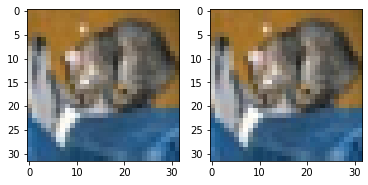

In [154]:
i=0
#i=78
print(f"true class: {cifar_classes[int(tsty[i])]}")
print(f"prediction: {cifar_classes[int(pred.argmax(1)[i])]}, proba: {pred.max(1)[i]}")
print(f"prediction: {cifar_classes[int(advpred.argmax(1)[i])]}, proba: {advpred.max(1)[i]}")

f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(tstX[i])
f.add_subplot(1,2, 2)
plt.imshow(a['tst_lip_1_pert'][i])
plt.plot()

In [159]:
from lolip.attacks.torch.projected_gradient_descent import ProjectedGradientDescent
i = 2
n = 200
nb_iter=10
eps = 0.031
attack_model = ProjectedGradientDescent(
    model_fn=model.model,
    norm=np.inf,
    eps=eps,
    eps_iter=eps*2/nb_iter,
    nb_iter=nb_iter,
)
adv_tstX = attack_model.perturb(tstX[:n], tsty[:n])
predpro = model.predict_proba(tstX[:n])
advpro = model.predict_proba(adv_tstX[:n])
proba = np.array([predpro[i][tsty[i]] for i in range(n)])
advproba = np.array([advpro[i][tsty[i]] for i in range(n)])

In [168]:
print(sorted([(p, i) for i, p in enumerate(advproba)])[::-1])

[(3.928364e-19, 38), (2.139491e-20, 50), (6.2324763e-21, 67), (7.5909937e-22, 14), (5.8268816e-22, 11), (2.890054e-23, 56), (2.0332044e-24, 45), (5.753915e-25, 41), (3.278957e-25, 89), (1.7603159e-25, 44), (4.0502673e-26, 23), (3.8533094e-26, 47), (3.400378e-26, 96), (3.983777e-27, 19), (2.5159128e-27, 93), (1.2369445e-27, 95), (7.5774886e-28, 82), (1.7982877e-28, 6), (1.7919399e-28, 76), (7.5623535e-29, 28), (6.4600397e-29, 92), (2.8477258e-29, 13), (6.962432e-30, 62), (4.382583e-30, 98), (4.076206e-30, 39), (3.408397e-30, 79), (7.753089e-31, 60), (6.6937868e-31, 90), (6.2585087e-31, 37), (6.050055e-31, 88), (3.8625567e-31, 80), (3.3014763e-31, 34), (2.4592397e-31, 81), (2.066421e-31, 1), (1.6975366e-31, 40), (5.7094654e-32, 4), (1.2647153e-32, 73), (1.2139842e-32, 69), (1.09526326e-32, 15), (1.0822801e-32, 9), (7.681779e-33, 66), (7.1334875e-33, 33), (5.092126e-33, 71), (3.8350386e-33, 29), (2.8612442e-33, 27), (1.5129782e-33, 77), (1.3103929e-33, 20), (3.4747925e-34, 2), (2.4914444e

[[9.60847202e-31 1.00000000e+00 1.60442974e-27 8.66779592e-30
  5.83278945e-32 8.44278725e-22 7.71061711e-31 1.03557711e-28
  1.10328465e-33 8.09422565e-25]]
true class: ship
prediction: car, proba: 1.0


W0106 13:19:10.995937 140719580231488 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


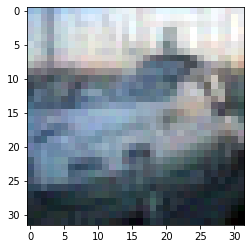

In [158]:
from lolip.attacks.torch.projected_gradient_descent import ProjectedGradientDescent
i = 2
nb_iter=10
eps = 0.031
attack_model = ProjectedGradientDescent(
    model_fn=model.model,
    norm=np.inf,
    eps=eps,
    eps_iter=eps*2/nb_iter,
    nb_iter=nb_iter,
)

adv_tstX = attack_model.perturb(tstX[i:i+1], tsty[i:i+1])
print(model.predict_proba(adv_tstX))
print(f"true class: {cifar_classes[int(tsty[i])]}")
print(f"prediction: {cifar_classes[int(model.predict(adv_tstX)[0])]}, proba: {model.predict_proba(adv_tstX).max(1)[0]}")

plt.imshow(adv_tstX[0])

(array([1.5200e+02, 6.5120e+03, 2.2573e+04, 2.0928e+04, 7.5230e+03,
        1.8900e+03, 3.4400e+02, 6.7000e+01, 8.0000e+00, 2.0000e+00]),
 array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50.],
       dtype=float32),
 <a list of 10 Patch objects>)

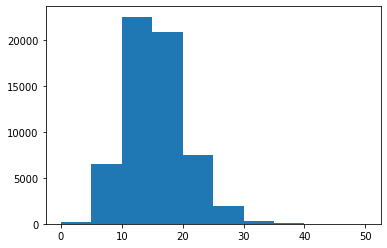

In [22]:
model_path = "./models/pgd-mnist-0.1-trades10ce-tor-CNN001-inf-0.pt"
model = globals()[get_arch(model_path)](n_classes=10)
model.load_state_dict(torch.load(model_path))
model.eval()
model.cuda()
trnX, trny, tstX, tsty = auto_var.get_var_with_argument("dataset", get_ds(model_path))

a = joblib.load("./results/experiment03/pgd-mnist-0.1-trades10ce-tor-CNN001-inf-0.pkl")
lip_ = calc_lip(model, trnX, a['trn_lip_1_pert'], top_norm=1, btm_norm=np.inf)
plt.hist(lip_, range=(0, 50))


{'epoch': 1, 'trn_loss': 1.1952014090855916, 'trn_acc': 0.8386, 'tst_loss': 0.11926027126312255, 'tst_acc': 0.9705}


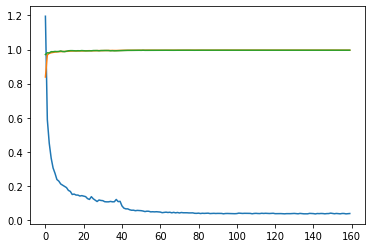

In [19]:
a = joblib.load("./results/experiment01/pgd-mnist-0.1-strades6ce-tor-CNN002-inf-0.pkl")
print(a['history'][0])
plt.plot([h['trn_loss'] for h in a['history']])
plt.plot([h['trn_acc'] for h in a['history']])
plt.plot([h['tst_acc'] for h in a['history']])

In [57]:
from scipy.special import kl_div

def kld(p, q):
    return p * np.log(p/q) + (1-p) * np.log((1-p)/(1-q))

def trades(p, advp, beta=1.0):
    return -np.log(p) + beta * kld(advp, p)

def ptrades(p, advp, beta=1.0):
    return -np.log(p) + beta * kld(advp, p) / np.linalg.norm(p - advp, ord=np.inf)

def ce(p):
    return -np.log(p)

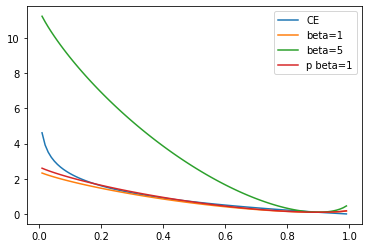

In [61]:
advp = np.arange(1, 101) / 100
plt.plot(advp, ce(advp), label="CE")
plt.plot(advp, trades(p=0.9, advp=advp, beta=1.0), label="beta=1")
plt.plot(advp, trades(p=0.9, advp=advp, beta=5.0), label="beta=5")
plt.plot(advp, ptrades(p=0.9, advp=advp, beta=1.0), label="p beta=1")
#plt.plot(advp, trades(p=0.95, advp=advp, beta=1.0), label="beta=5")
plt.legend()

/home/arbiter/.pyenv/versions/3.7.4/envs/general/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/home/arbiter/.pyenv/versions/3.7.4/envs/general/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


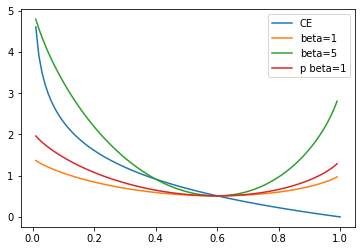

In [64]:
advp = np.arange(1, 101) / 100
plt.plot(advp, ce(advp), label="CE")
plt.plot(advp, trades(p=0.6, advp=advp, beta=1.0), label="beta=1")
plt.plot(advp, trades(p=0.6, advp=advp, beta=5.0), label="beta=5")
plt.plot(advp, ptrades(p=0.6, advp=advp, beta=1.0), label="p beta=1")

#plt.plot(advp, trades(p=0.95, advp=advp, beta=1.0), label="beta=5")
plt.legend()

In [ ]:
def plot_boundary(xx)
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot also the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='black', s=25)
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
               alpha=0.6, edgecolors='black', s=25)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())

In [ ]:
auto_var.set_variable_value("random_seed", 0)
trnX, trny, tstX, tsty = auto_var.get_var_with_argument("dataset", "halfmoon-1000-0.25")
model = TorchModel(lbl_enc=None, n_features=(2, ), n_classes=2, architecture="MLP", epochs=60, learning_rate=1e-2)
_ = model.fit(trnX, trny, verbose=0)

In [7]:
trnX.shape
tstX.shape

(750,)